### Problem Description

The **Bin Packing Problem** involves assigning `item_num` items, each with a size specified in `item_size`, to bins of fixed capacity `bin_size`, with the objective of minimizing the total number of bins used.

#### Constraints:

1. **Assignment Constraint**: Each item must be placed in exactly one bin.
2. **Capacity Constraint**: The combined size of items in any bin cannot exceed `bin_size`.

The ILP format of the problem can be generated through the following function:


In [28]:
from qiskit_optimization.translators.docplex_mp import to_docplex_mp
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization import QuadraticProgram


def generate_ILP(item_num, bin_size, item_size):

    # Initialize a QuadraticProgram
    qp = QuadraticProgram(name="Bin Packing Problem")

    # Define variables
    # x[i, j] is 1 if item i is placed in bin j, 0 otherwise
    for i in range(item_num):
        for j in range(item_num):
            qp.binary_var(name=f"x_{i}_{j}")

    # y[j] is 1 if bin j is used, 0 otherwise
    for j in range(item_num):
        qp.binary_var(name=f"y_{j}")

    # Objective: Minimize the number of bins used
    qp.minimize(linear={f"y_{j}": 1 for j in range(item_num)})

    # Constraints
    # 1. Each item must be placed in exactly one bin
    for i in range(item_num):
        qp.linear_constraint(
            linear={f"x_{i}_{j}": 1 for j in range(item_num)},
            sense="==",
            rhs=1,
            name=f"item_assignment_{i}",
        )

    # 2. Bin capacity constraints
    for j in range(item_num):
        qp.linear_constraint(
            linear={f"x_{i}_{j}": item_size[i] for i in range(item_num)}
            | {f"y_{j}": -bin_size},
            sense="<=",
            rhs=0,
            name=f"bin_capacity_{j}",
        )

    print(qp.prettyprint())

    return qp

### Convert to Quadratic Unconstrained Binary Optimization (QUBO)

To incorporate the bin assignment constraint into the objective function, we add a penalty term: `penalty * (number of bins an item is assigned to - 1)^2`. For the capacity constraint, there are two approaches:

1. **Introduce a Slack Variable**: Add an integer slack variable for each bin, representing the unused capacity in the range `[0, bin_size]`, then convert it into binary form.
   - **Pro**: Allows fine-tuning of the capacity constraint penalty through the slack variable.
   - **Con**: Requires `item_num * ceil(log2(bin_size))` additional qubits, increasing circuit complexity.

2. **Penalty-Based Capacity Constraint**: Add a term `penalty * (assigned item sizes - bin_size)^2` to the objective function.
   - **Pro**: Does not require additional qubits.
   - **Con**: This method equally penalizes both overflow and under-utilization of bin capacity, whereas ideally, overflow should incur a higher penalty.

Both approaches can achieve accurate results. Since the penalty-based approach produces a simpler circuit, I decided to use it for the following tests.

**Future Improvement**: Experiment with a non-symmetric penalty function that imposes a harsher penalty on capacity overflow. A potential approach could involve using the first three terms of the Taylor series of \( e^x \):
$$
1 + x + \frac{x^2}{2}
$$
The exact parameters could be fine tuned based on the specific item_size and bin_size.


   

In [29]:
##Introduce a Slack Variable
from qiskit_optimization.converters import QuadraticProgramToQubo

def generate_QUBO_with_slack():
    ilp = generate_ILP(item_num, bin_size, item_size)
    conv = QuadraticProgramToQubo()
    return conv.convert(ilp)

In [30]:
## Penalty-Based Capacity Constraint
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp

def generate_QUBO(item_num, bin_size, item_size, lambda1=100, lambda2=100):
    # Initialize DOcplex Model
    model = Model(name="Bin Packing Problem QUBO")

    # Define binary variables
    x = {}
    for i in range(item_num):
        for j in range(item_num):
            x[i, j] = model.binary_var(name=f"x_{i}_{j}")

    y = {}
    for j in range(item_num):
        y[j] = model.binary_var(name=f"y_{j}")

    # Objective: Minimize the number of bins used
    objective = model.sum(y[j] for j in range(item_num))

    # Penalty for Item Assignment Constraint (each item must be in exactly one bin)
    item_assignment_penalty = lambda1 * model.sum(
        (model.sum(x[i, j] for j in range(item_num)) - 1) ** 2 for i in range(item_num)
    )

    # Penalty for Bin Capacity Constraint
    bin_capacity_penalty = lambda2 * model.sum(
        (model.sum(item_size[i] * x[i, j] for i in range(item_num)) - bin_size * y[j])
        ** 2
        for j in range(item_num)
    )

    # Combine all terms into the objective function
    model.minimize(objective + item_assignment_penalty + bin_capacity_penalty)
    print(model.lp_string)
    qubo = from_docplex_mp(model)
    return qubo

### Instance Setup

1. **Small**: `bin_size = 10`, `item_num = 2`
2. **Medium**: `bin_size = 10`, `item_num = 3`
3. **Large**: `bin_size = 10`, `item_num = 4`

In [ ]:
import numpy as np

seed = 1
np.random.seed(seed)
item_num = 0
bin_size = 10


item_num_small = 2
item_size = np.random.randint(1, bin_size, size=item_num_small)
qubo_small = generate_QUBO(item_num_small, bin_size, item_size)

item_num_medium = 3
item_size = np.random.randint(1, bin_size, size=item_num_medium)
qubo_medium = generate_QUBO(item_num_medium, bin_size, item_size)

item_num_large = 4
item_size = np.random.randint(1, bin_size, size=item_num_large)
qubo_large = generate_QUBO(item_num_large, bin_size, item_size)

### Solve the Problem with Classical Optimization Solvers (CPLEX)

Solving a QUBO of this scale is relatively straightforward using CPLEX.

In [32]:
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization import QuadraticProgram


def solve_with_Cplex(qubo):

    cplex_optimizer = CplexOptimizer()

    result_qubo = cplex_optimizer.solve(qubo)
    print(result_qubo)
    return result_qubo


qubo_small_result = solve_with_Cplex(qubo_small)
qubo_medium_result = solve_with_Cplex(qubo_medium)
qubo_large_result = solve_with_Cplex(qubo_large)

fval=200.0, x_0_0=0, x_0_1=0, x_1_0=0, x_1_1=0, y_0=0, y_1=0, status=SUCCESS
fval=300.0, x_0_0=0, x_0_1=0, x_0_2=0, x_1_0=0, x_1_1=0, x_1_2=0, x_2_0=0, x_2_1=0, x_2_2=0, y_0=0, y_1=0, y_2=0, status=SUCCESS
fval=2.0, x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_0_3=0.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=0.0, x_3_1=0.0, x_3_2=0.0, x_3_3=1.0, y_0=1.0, y_1=0.0, y_2=0.0, y_3=1.0, status=SUCCESS


### Solve with Quantum Variational Approach

#### General Workflow

1. **Initial Setup**:

   - **Ansatz**: I experimented with two ansatz options, **QAOA** and **EfficientSU2**, to represent the search space.

   - **Cost Function**: The QUBO problem is reformulated as a Hamiltonian, where the ground state corresponds to the solution that minimizes the cost function.

2. **Optimize Parameters with Classical Optimizer**: I used the `minimize` method from `scipy.optimize` as the classical optimizer. This method iteratively explores the search space by evaluating the cost function with the current parameters, then adjusting parameters for the next iteration until convergence on an optimal solution.

3. **Sample Circuit**: Once the optimal parameters are obtained, they are assigned to the circuit. The final distribution is then sampled using the optimized parameters. I configure the sampler to take 10000 shots for the tests

4. **Analyze Results**: I evaluated the final results using the following metrics:
   - Minimum number of bins used
   - Optimal solution percentage
   - Valid solution percentage
   - Constraint violation percentage
   - Runtime



In [33]:
from qiskit.providers import JobStatus


def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance


    Returns:
        float: Energy estimate
    """
    max_retries = 100
    retry_delay = 60
    pub = (ansatz, [hamiltonian], [params])

    for attempt in range(max_retries):
        try:
            job = estimator.run(pubs=[pub])  # Attempt job submission
            # print(f">>> Job ID: {job.job_id()}")

            break  # Exit loop if job submission is successful
        except Exception as e:
            print(f"Job submission failed on attempt {attempt + 1}: {e}")
            if attempt < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Max retries reached. Returning high cost.")
                return float("inf")  # Return high value if max retries are reached

    try:
        result = job.result()
        energy = result[0].data.evs[0]
        return energy  # Assuming the result is a single value for optimization
    except Exception as e:
        print(f"Error retrieving job result: {e}")
        return float("inf")  # Return high cost in case of retrieval error

In [34]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Estimator, Sampler, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import numpy as np
from scipy.optimize import minimize


def optimize_ansatz(ansatz, backend):

    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
    init_params = 2 * np.pi * np.random.rand(ansatz.num_parameters)

    estimator = Estimator(mode=backend)
    result = minimize(
        cost_func,
        init_params,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
    )

    optimized_circuit = ansatz_isa.assign_parameters(result.x)
    return optimized_circuit

In [35]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

In [36]:
from qiskit_ibm_runtime import SamplerV2 as Sampler


def sample_circuit(optimized_circuit, backend):

    sampler = Sampler(mode=backend)
    sampler.options.default_shots = 10000

    pub = (optimized_circuit,)
    job = sampler.run([pub], shots=int(1e4))
    counts_int = job.result()[0].data.meas.get_int_counts()
    return counts_int

In [1]:
def analyze_result(counts_int):
    total_valid = 0                       # Counter for valid solutions
    total_valid_count = 0                 # Total count of valid solutions
    total_invalid = 0                     # Counter for invalid solutions
    total_invalid_count = 0               # Total count of invalid solutions
    bin_constraint_invalid_count = 0      # Total count of bin constraint violation solutions
    capacity_constraint_invalid_count = 0 # Total count of capacity constraint violation solutions
    both_constraints_invalid_count = 0    # Total count of solutions violating both constraints
    min_bins_used = item_num + 1          # Start with a high number of bins as max
    optimal_solution = []                 # Placeholder for the optimal solution configuration
    optimal_solution_count = 0            # Counter for optimal solution occurrences
    
    # Analyze each solution, sorted by occurrence count in descending order
    for key, count in sorted(
        counts_int.items(), key=lambda item: item[1], reverse=True
    ):
        # Convert key to a bitstring and reverse it
        solution_bitstring = to_bitstring(key, num_qubits)
        solution_bitstring.reverse()

        # Validate the result and get bins used
        valid_code, bins_used = validate_result(
            solution_bitstring, item_num, bin_size, item_size
        )

        if valid_code == 0:  # Valid solution
            total_valid += 1
            total_valid_count += count

            # Check if this solution uses fewer bins
            if bins_used < min_bins_used:
                min_bins_used = bins_used
                optimal_solution = solution_bitstring
                optimal_solution_count = (
                    count  # Reset count for the new optimal solution
                )
            elif bins_used == min_bins_used:
                optimal_solution_count += (
                    count  # Increment for additional optimal solutions
                )
        else:  # Invalid solution
            total_invalid += 1
            total_invalid_count += count

            # Increment specific violation counters
            if valid_code == 1:
                bin_constraint_invalid_count += count
            elif valid_code == 2:
                capacity_constraint_invalid_count += count
            elif valid_code == 3:
                both_constraints_invalid_count += count

    total_count = total_valid_count + total_invalid_count

    # Calculate the percentage of valid solutions and specific violations
    valid_percentage = (total_valid_count / total_count) * 100 if total_count > 0 else 0
    optimal_percentage = (
        (optimal_solution_count / total_count) * 100 if total_count > 0 else 0
    )
    bin_constraint_invalid_percentage = (
        (bin_constraint_invalid_count / total_count) * 100 if total_count > 0 else 0
    )
    capacity_constraint_invalid_percentage = (
        (capacity_constraint_invalid_count / total_count) * 100
        if total_count > 0
        else 0
    )
    both_constraints_invalid_percentage = (
        (both_constraints_invalid_count / total_count) * 100 if total_count > 0 else 0
    )

    # Print results
    print(f"Minimum bins used: {min_bins_used}")
    print(f"Optimal solution: {optimal_solution}")
    print(f"Optimal solution percentage: {optimal_percentage:.2f}%")
    print(f"Valid solution percentage: {valid_percentage:.2f}%")
    print(
        f"Bin constraint violation percentage: {bin_constraint_invalid_percentage:.2f}%"
    )
    print(
        f"Capacity constraint violation percentage: {capacity_constraint_invalid_percentage:.2f}%"
    )
    print(
        f"Both constraints violation percentage: {both_constraints_invalid_percentage:.2f}%"
    )

    # Return results as an array of percentages
    return [
        min_bins_used,
        optimal_solution,
        optimal_percentage,
        valid_percentage,
        bin_constraint_invalid_percentage,
        capacity_constraint_invalid_percentage,
        both_constraints_invalid_percentage,
    ]

In [38]:
def validate_result(bin_result, item_num, bin_capacity, item_sizes):
    """
    Validates the bin-packing result and calculates the number of bins used if valid.

    Parameters:
    - bin_result: List[int], a 1D array representing the bin-packing result.
    - item_num: int, the number of items to be packed.
    - bin_capacity: int, the capacity of each bin.
    - item_sizes: List[int], the size of each item.

    Returns:
    - (int, int): A tuple where the first element is the validity code:
                   0 -> valid result
                   1 -> bin assignment constraint violation
                   2 -> bin capacity constraint violation
                   3 -> violation of both constraints
                   and the second element is the number of bins used if valid.
    """
    bin_loads = {}
    assignment_violation = False
    capacity_violation = False

    # Check if each item is assigned to exactly one bin
    for item_index in range(item_num):
        item_count = 0
        for bin_index in range(item_num):
            if bin_result[item_index * item_num + bin_index] == 1:
                item_count += 1
                # Track total size per bin for capacity check
                if bin_index not in bin_loads:
                    bin_loads[bin_index] = 0
                bin_loads[bin_index] += item_sizes[item_index]

        # If item is assigned to more than one bin or no bin, set assignment_violation
        if item_count != 1:
            assignment_violation = True

    # Check if any bin exceeds its capacity
    bins_used = 0
    for bin_index in range(item_num):
        bin_used = bin_result[item_num * item_num + bin_index]  # Accessing bin usage
        if bin_index in bin_loads:
            # Bin is marked as unused but has items
            if bin_used == 0:
                capacity_violation = True
            # Check if bin load exceeds capacity
            if bin_used * bin_capacity < bin_loads[bin_index]:
                capacity_violation = True
            bins_used += 1
        else:
            # Bin is marked as used, but has no items
            if bin_used == 1:
                capacity_violation = True

    # Determine return value based on violations
    if assignment_violation and capacity_violation:
        return 3, item_num
    elif assignment_violation:
        return 1, item_num
    elif capacity_violation:
        return 2, item_num
    else:
        return 0, bins_used

In [40]:
def run_QAOA_v1(backend):

    ansatz = QAOAAnsatz(hamiltonian)
    ansatz.measure_all()
    optimized_circuit = optimize_ansatz(ansatz, backend)
    counts_int = sample_circuit(optimized_circuit, backend)
    end_time = time.time()

    result = analyze_result(counts_int)
    print(result)

In [41]:
from qiskit.circuit.library import QAOAAnsatz, EfficientSU2
import numpy as np
import time

item_num = item_num_large
hamiltonian, offset = qubo_large.to_ising()
num_qubits = hamiltonian.num_qubits

backend = AerSimulator()
run_QAOA_v1(backend)

Minimum bins used: 2
Optimal solution: [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]
Optimal solution percentage: 0.02%
Valid solution percentage: 0.02%
Bin constraint violation percentage: 0.57%
Capacity constraint violation percentage: 1.32%
Both constraints violation percentage: 98.09%
[2, [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0], 0.02, 0.02, 0.5700000000000001, 1.32, 98.09]


### Ansatz Analysis

#### QAOA

Each layer of QAOA is composed of a **cost Hamiltonian** and a **mixer Hamiltonian**. The cost Hamiltonian lowers the system’s energy towards the ground state, while the mixer Hamiltonian shifts the state to explore a broader solution space. 

##### Custom Mixer
Upon inspecting the results from `run_QAOA_v1`, it appears that a majority of the solutions are invalid. We can address the bin constraint violations by setting up a bin-assignment-compliant initial state and creating a custom mixer that permutes the state in a way that guarantees each item is assigned to only one bin. With this adjustment, **bin constraint violations can be entirely eliminated**.


In [42]:
from qiskit import QuantumCircuit


def generate_valid_initial_state(item_num, num_qubits):
    initial_state_bits = ["0"] * num_qubits  # Start with all qubits in |0>

    for item in range(item_num):
        # Randomly assign this item to a single bin
        bin_assignment = np.random.randint(0, item_num - 1)
        initial_state_bits[item * item_num + bin_assignment] = "1"

    # Initialize a quantum circuit with the required number of qubits
    initial_state_circuit = QuantumCircuit(num_qubits)

    # Apply X gates to qubits that should start in |1⟩
    for idx, bit in enumerate(initial_state_bits):
        if bit == "1":
            initial_state_circuit.x(idx)

    return initial_state_circuit

In [43]:
from qiskit.quantum_info import SparsePauliOp


def create_single_item_mixer(item_num, num_bins, num_total_qubits):
    terms = []

    # Step 1: Apply single-item mixer for item-bin qubits (enforcing one "1" per item across bins)
    for item in range(item_num):
        # Define the start and end indices for this item's bin qubits
        start_index = item * num_bins
        end_index = start_index + num_bins

        # Create XY-type swap terms within each item's bin qubits
        for i in range(start_index, end_index):
            for j in range(i + 1, end_index):
                # X_i X_j term (swaps state between qubits i and j)
                pauli_xx = ["I"] * num_total_qubits
                pauli_xx[i] = "X"
                pauli_xx[j] = "X"
                pauli_xx.reverse()
                terms.append(("".join(pauli_xx), 1.0))

                # Y_i Y_j term (swaps state between qubits i and j)
                pauli_yy = ["I"] * num_total_qubits
                pauli_yy[i] = "Y"
                pauli_yy[j] = "Y"
                pauli_yy.reverse()
                terms.append(("".join(pauli_yy), 1.0))

    # Step 2: Apply default Pauli-X flipping for the remaining qubits
    # These additional qubits will freely flip between |0> and |1> like a standard mixer
    for extra_qubit in range(item_num * num_bins, num_total_qubits):
        pauli_x = ["I"] * num_total_qubits
        pauli_x[extra_qubit] = "X"
        pauli_x.reverse()
        terms.append(("".join(pauli_x), 1.0))

    # Create SparsePauliOp from the list of terms
    mixer_hamiltonian = SparsePauliOp.from_list(terms)
    return mixer_hamiltonian

In [44]:
result_dict = {}

In [45]:
def run_QAOA(backend, deps):
    valid_initial_state = generate_valid_initial_state(item_num, num_qubits)
    single_item_mixer = create_single_item_mixer(item_num, item_num, num_qubits)

    for i in range(1, deps):

        start_time = time.time()
        ansatz = QAOAAnsatz(
            hamiltonian,
            reps=i,
            mixer_operator=single_item_mixer,
            initial_state=valid_initial_state,
        )
        ansatz.measure_all()
        # ansatz.decompose().draw("mpl", style="iqp")

        optimized_circuit = optimize_ansatz(ansatz, backend)
        counts_int = sample_circuit(optimized_circuit, backend)
        end_time = time.time()
        execution_time = end_time - start_time

        result = analyze_result(counts_int)
        result.append(execution_time)
        result.append("QAOA")
        result.append(item_num)
        result.append(i)
        result_dict[f"QAOAAnsatz item_num={item_num} rep={i}"] = result

In [46]:
item_num = item_num_large
hamiltonian, offset = qubo_large.to_ising()
num_qubits = hamiltonian.num_qubits
run_QAOA(backend, 2)

Minimum bins used: 2
Optimal solution: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Optimal solution percentage: 0.03%
Valid solution percentage: 9.14%
Bin constraint violation percentage: 0.00%
Capacity constraint violation percentage: 90.86%
Both constraints violation percentage: 0.00%


#### Circuit Depths

With more iterations, QAOA can explore a larger portion of the search space, increasing the chances of finding the optimal solution. However, deeper circuits also lead to greater complexity and exposure to noise. 

I ran the experiment with medium instance on the Aer simulator with circuit depths ranging from 1 to 9. As shown in the following graph:
- **Low circuit depths** (1-2) yield a low optimal solution percentage,sometimes even failed to find the optimal solution
- **High circuit depths** (>5) show diminishing returns, with minimal improvement despite the increased cost.

Therefore, a circuit depth in the range of **4-5** appears most suitable for this experiment setup.


In [ ]:
item_num = item_num_medium
hamiltonian, offset = qubo_medium.to_ising()
num_qubits = hamiltonian.num_qubits
run_QAOA(backend, 10)

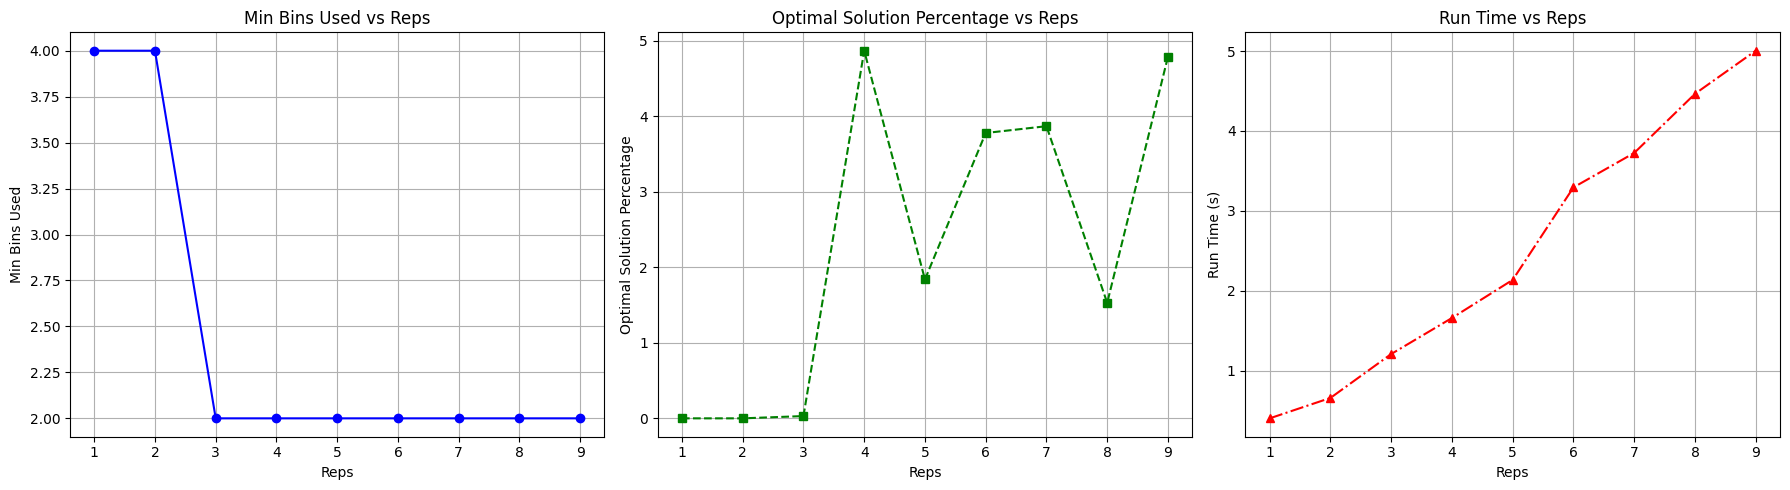

In [72]:
import matplotlib.pyplot as plt

filtered_entry = [
    entry for entry in result_dict.values() if "QAOA" in entry and entry[9] == 3
]
reps = [entry[10] for entry in filtered_entry]  # reps
min_bin = [entry[0] for entry in filtered_entry]
optimal_solution_percentage = [entry[2] for entry in filtered_entry]
run_time = [entry[7] for entry in filtered_entry]

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Min Bins Used
axes[0].plot(reps, min_bin, marker="o", linestyle="-", color="b")
axes[0].set_xlabel("Reps")
axes[0].set_ylabel("Min Bins Used")
axes[0].set_title("Min Bins Used vs Reps")
axes[0].grid(True)

# Plot Optimal Solution Percentage
axes[1].plot(reps, optimal_solution_percentage, marker="s", linestyle="--", color="g")
axes[1].set_xlabel("Reps")
axes[1].set_ylabel("Optimal Solution Percentage")
axes[1].set_title("Optimal Solution Percentage vs Reps")
axes[1].grid(True)

# Plot Run Time
axes[2].plot(reps, run_time, marker="^", linestyle="-.", color="r")
axes[2].set_xlabel("Reps")
axes[2].set_ylabel("Run Time (s)")
axes[2].set_title("Run Time vs Reps")
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### EfficientSU2

EfficientSU2 is a flexible and highly configurable ansatz, featuring layers of parameterized single-qubit rotations and entangling gates. I experimented with all rotation strategies and `entanglement_options` for circuit depths from 1 to 7 on a medium instance.

Variance across different runs was significant, and without a clear best configuration, I chose `["rx", "ry", "rz"]` rotations to cover all rotation possibilities and circular entanglement as a middle-ground option. A full entanglement could be costly for large circuits. Since this is a simulation, the final choice should also consider the hardware’s native connectivity. For instance, "linear" entanglement would be preferred on a device with linear qubit connectivity. I selected depth 5 to balance accuracy with computational cost.


In [53]:
su2_gates_options = [["ry"], ["rz"], ["rx"], ["ry", "rz"], ["rx", "ry", "rz"]]
entanglement_options = ["linear", "circular", "full"]
chosen_su2_gates_options = [["rx", "ry", "rz"]]
chosen_entanglement_options = ["circular"]

In [54]:
def run_EfficientSU2(
    backend, deps_start, deps_end, su2_gates_options, entanglement_options
):
    valid_initial_state = generate_valid_initial_state(item_num, num_qubits)

    for i in range(deps_start, deps_end):
        for su2_gates in su2_gates_options:
            for entanglement in entanglement_options:
                start_time = time.time()
                ansatz = EfficientSU2(
                    num_qubits,
                    reps=i,
                    initial_state=valid_initial_state,
                    su2_gates=su2_gates,
                    entanglement=entanglement,
                    skip_unentangled_qubits=True,
                )
                ansatz.measure_all()

                optimized_circuit = optimize_ansatz(ansatz, backend)
                counts_int = sample_circuit(optimized_circuit, backend)
                end_time = time.time()
                execution_time = end_time - start_time
                result = analyze_result(counts_int)
                result.append(execution_time)
                result.append("EfficientSU2")
                result.append(item_num)
                result.append(i)
                result.append(su2_gates)
                result.append(entanglement)
                result_dict[
                    f"EfficientSU2 item_num={item_num}reps={i}, su2_gates={su2_gates} and entanglement={entanglement}"
                ] = result

In [ ]:
item_num = item_num_medium
hamiltonian, offset = qubo_medium.to_ising()
num_qubits = hamiltonian.num_qubits

run_EfficientSU2(backend, 1, 7, su2_gates_options, entanglement_options)

In [50]:
import matplotlib.pyplot as plt

# Filter entries with 'EfficientSU2'
su2_entries = [entry for entry in result_dict.values() if "EfficientSU2" in entry]

# Calculate averages for su2_gates options
su2_gates_labels = [", ".join(gates) for gates in su2_gates_options]

average_min_bins_gates = []
average_run_time_gates = []
average_optimal_percentages_gates = []

for su2_gates in su2_gates_options:
    filtered_entries = [entry for entry in su2_entries if entry[11] == su2_gates]
    filtered_values = [entry[2] for entry in su2_entries if entry[11] == su2_gates]

    min_bins = [entry[0] for entry in filtered_entries]
    run_times = [entry[7] for entry in filtered_entries]
    optimal_solution_percentages = [entry[2] for entry in filtered_entries]

    # Calculate averages and append them to lists
    average_min_bins_gates.append(sum(min_bins) / len(min_bins) if min_bins else 0)
    average_run_time_gates.append(sum(run_times) / len(run_times) if run_times else 0)
    average_optimal_percentages_gates.append(
        sum(optimal_solution_percentages) / len(optimal_solution_percentages)
        if optimal_solution_percentages
        else 0
    )


# Calculate averages for entanglement
average_min_bins_entanglement = []
average_run_time_entanglement = []
average_optimal_percentages_entanglement = []

for entanglement in entanglement_options:
    filtered_entries = [entry for entry in su2_entries if entry[12] == entanglement]

    min_bins = [entry[0] for entry in filtered_entries]
    run_times = [entry[7] for entry in filtered_entries]
    optimal_solution_percentages = [entry[2] for entry in filtered_entries]

    # Calculate averages and append them to lists
    average_min_bins_entanglement.append(
        sum(min_bins) / len(min_bins) if min_bins else 0
    )
    average_run_time_entanglement.append(
        sum(run_times) / len(run_times) if run_times else 0
    )
    average_optimal_percentages_entanglement.append(
        sum(optimal_solution_percentages) / len(optimal_solution_percentages)
        if optimal_solution_percentages
        else 0
    )


# Calculate averages for depth
average_min_bins_depth = []
average_run_time_depth = []
average_optimal_percentages_depth = []
depth_options = [i for i in range(1, 7)]
for depth in depth_options:
    filtered_entries = [entry for entry in su2_entries if entry[10] == depth]

    min_bins = [entry[0] for entry in filtered_entries]
    run_times = [entry[7] for entry in filtered_entries]
    optimal_solution_percentages = [entry[2] for entry in filtered_entries]

    # Calculate averages and append them to lists
    average_min_bins_depth.append(sum(min_bins) / len(min_bins) if min_bins else 0)
    average_run_time_depth.append(sum(run_times) / len(run_times) if run_times else 0)
    average_optimal_percentages_depth.append(
        sum(optimal_solution_percentages) / len(optimal_solution_percentages)
        if optimal_solution_percentages
        else 0
    )

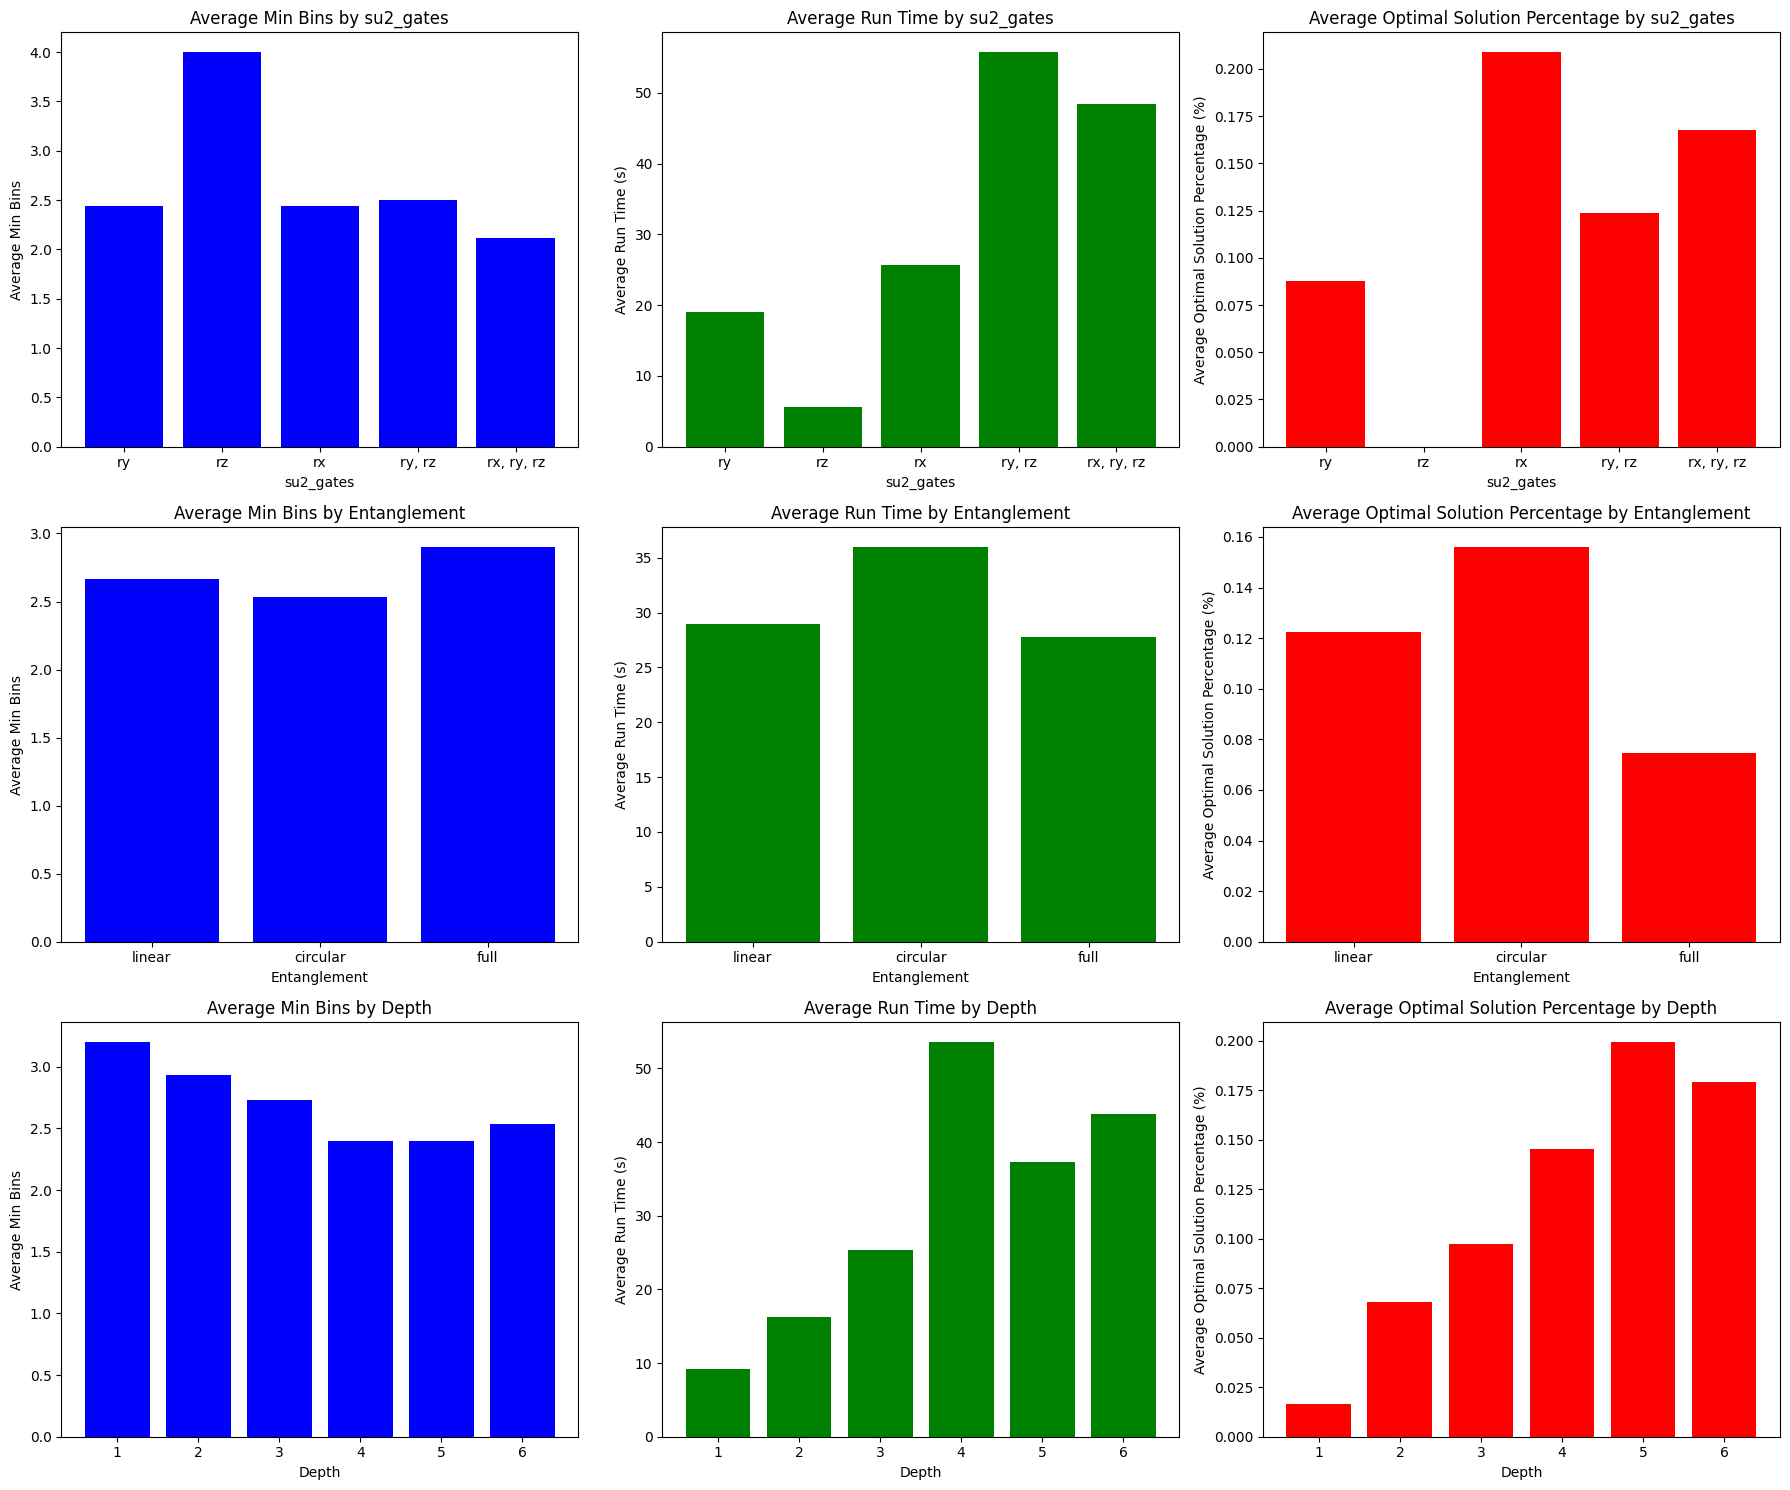

In [51]:
# Plot for su2_gates
su2_gates_labels = [", ".join(gates) for gates in su2_gates_options]

# Plotting results
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Plot for su2_gates
axes[0, 0].bar(su2_gates_labels, average_min_bins_gates, color="blue")
axes[0, 0].set_title("Average Min Bins by su2_gates")
axes[0, 0].set_xlabel("su2_gates")
axes[0, 0].set_ylabel("Average Min Bins")

axes[0, 1].bar(su2_gates_labels, average_run_time_gates, color="green")
axes[0, 1].set_title("Average Run Time by su2_gates")
axes[0, 1].set_xlabel("su2_gates")
axes[0, 1].set_ylabel("Average Run Time (s)")

axes[0, 2].bar(su2_gates_labels, average_optimal_percentages_gates, color="red")
axes[0, 2].set_title("Average Optimal Solution Percentage by su2_gates")
axes[0, 2].set_xlabel("su2_gates")
axes[0, 2].set_ylabel("Average Optimal Solution Percentage (%)")

# Plot for entanglement
axes[1, 0].bar(entanglement_options, average_min_bins_entanglement, color="blue")
axes[1, 0].set_title("Average Min Bins by Entanglement")
axes[1, 0].set_xlabel("Entanglement")
axes[1, 0].set_ylabel("Average Min Bins")

axes[1, 1].bar(entanglement_options, average_run_time_entanglement, color="green")
axes[1, 1].set_title("Average Run Time by Entanglement")
axes[1, 1].set_xlabel("Entanglement")
axes[1, 1].set_ylabel("Average Run Time (s)")

axes[1, 2].bar(
    entanglement_options, average_optimal_percentages_entanglement, color="red"
)
axes[1, 2].set_title("Average Optimal Solution Percentage by Entanglement")
axes[1, 2].set_xlabel("Entanglement")
axes[1, 2].set_ylabel("Average Optimal Solution Percentage (%)")

# Plot for depth
axes[2, 0].bar(depth_options, average_min_bins_depth, color="blue")
axes[2, 0].set_title("Average Min Bins by Depth")
axes[2, 0].set_xlabel("Depth")
axes[2, 0].set_ylabel("Average Min Bins")

axes[2, 1].bar(depth_options, average_run_time_depth, color="green")
axes[2, 1].set_title("Average Run Time by Depth")
axes[2, 1].set_xlabel("Depth")
axes[2, 1].set_ylabel("Average Run Time (s)")

axes[2, 2].bar(depth_options, average_optimal_percentages_depth, color="red")
axes[2, 2].set_title("Average Optimal Solution Percentage by Depth")
axes[2, 2].set_xlabel("Depth")
axes[2, 2].set_ylabel("Average Optimal Solution Percentage (%)")

plt.tight_layout()
plt.show()

### QAOA vs EfficientSU2

I ran QAOA with depth 5 and EfficientSU2 with `["rx", "ry", "rz"]` rotations, circular entanglement, and depth 5 on the large instance. 

As shown in the following graph, both approaches were able to obtain the optimal solution. However, QAOA returned the optimal solution with a higher percentage among the samples and required less runtime. This makes QAOA better suited for the bin packing problem. The ability to customize the mixer in QAOA to ensure all permutations respect the bin assignment constraints significantly increases its optimal solution percentage.


In [ ]:
item_num = item_num_large
hamiltonian, offset = qubo_large.to_ising()
num_qubits = hamiltonian.num_qubits

run_EfficientSU2(backend, 5, 6, chosen_su2_gates_options, chosen_entanglement_options)

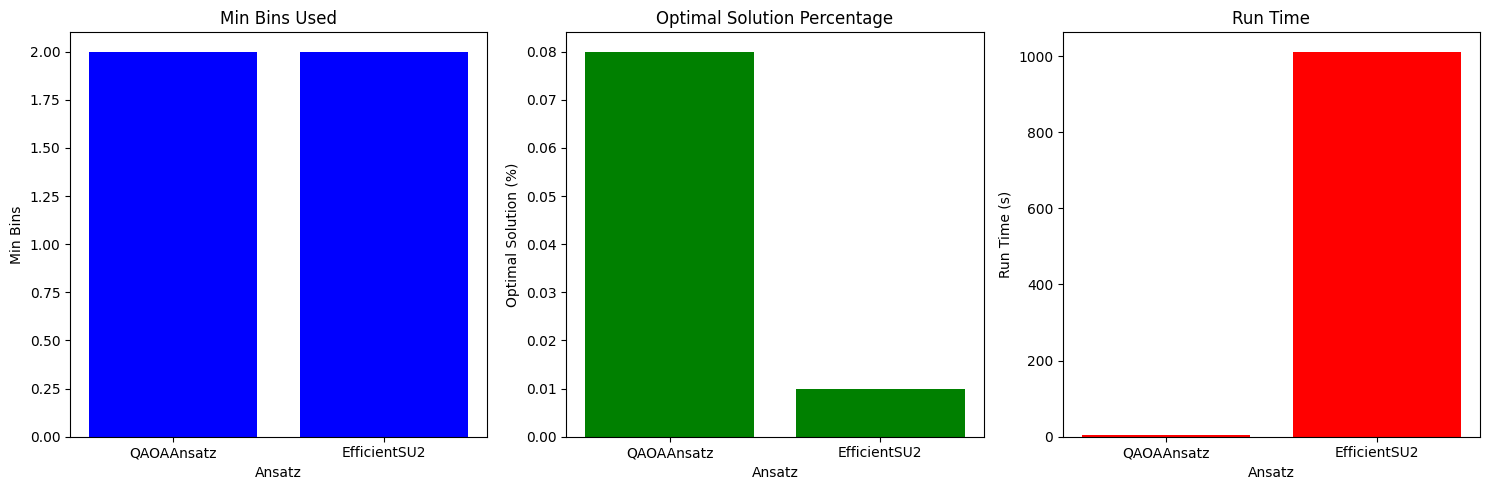

In [66]:
import matplotlib.pyplot as plt

chosen_entry_name = [
    "QAOAAnsatz item_num=4 rep=1",
    "EfficientSU2 item_num=4reps=5, su2_gates=['rx', 'ry', 'rz'] and entanglement=circular",
]

# Filter entries in result_dict where the key matches any name in chosen_entry_name
filtered_entries = [
    value for key, value in result_dict.items() if key in chosen_entry_name
]

min_bin = [entry[0] for entry in filtered_entries]
optimal_solution_percentage = [entry[2] for entry in filtered_entries]
run_time = [entry[7] for entry in filtered_entries]

# Labels for the chosen entries
labels = [
    label.split(" ")[0] for label in chosen_entry_name
]  # Use first part of the key as label (e.g., "QAOAAnsatz")


# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot min_bin
axes[0].bar(labels, min_bin, color="blue")
axes[0].set_title("Min Bins Used")
axes[0].set_xlabel("Ansatz")
axes[0].set_ylabel("Min Bins")

# Plot optimal_solution_percentage
axes[1].bar(labels, optimal_solution_percentage, color="green")
axes[1].set_title("Optimal Solution Percentage")
axes[1].set_xlabel("Ansatz")
axes[1].set_ylabel("Optimal Solution (%)")

# Plot run_time
axes[2].bar(labels, run_time, color="red")
axes[2].set_title("Run Time")
axes[2].set_xlabel("Ansatz")
axes[2].set_ylabel("Run Time (s)")

plt.tight_layout()
plt.show()

### Testing the Algorithm on IBM Cloud

With the Aer simulator locally, `item_num=4` is the maximum I can run. Unfortunately, it’s unfeasible to test larger instances on IBM Quantum Cloud with a trial plan. The parameter optimization step requires issuing hundreds of quantum calculation jobs, but the trial plan does not support session execution mode, which would allow for batching these jobs.

With a trial open plan, I am limited to issuing up to 3 pending jobs at a time. Once these pending jobs complete, the `check_pending_jobs` function in `QiskitRuntimeService`, used for scheduling, does not update for an hour, making it impossible to run the algorithm on the cloud.


### Potential Improvement

1. **Solve the Problem Recursively for Problems with a Large Number of Items**  
   The parameter optimization process becomes increasingly costly as `item_num` grows. Here are three ideas for decomposing the problem into smaller subproblems and recombining the results:

   - **Divide and Conquer**: Split the large problem into smaller subproblems, solve them individually, and then combine their results to form the final solution.
   
   - **Use Subproblem Results as an Initial State**: Combine results from subproblems to create an initial state for the full problem. Since this combined result is already a partially optimized valid solution, starting from this state can help the optimization process converge more quickly.
   
   - **Balanced Item Distribution**: When dividing items into subproblems, ensure each subproblem includes a balanced range of item sizes. This can help prevent situations where one subproblem’s bins have slack but the items that could fill it are assigned to different subproblems.

2. **Consider Noise/Error when Deciding Ansatz Parameters**  
   When selecting ansatz parameters, it’s crucial to account for noise and error rates, as they can significantly impact performance and accuracy. I created an `AerSimulator` with depolarizing noise and errors for single- and two-qubit gates. This setup works well for small and medium instances but runs very slowly for larger instances. Further effort is needed to make the noise/error simulation lightweight enough to run efficiently on large instances while still providing realistic noise modeling.




In [73]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit_aer.noise.errors import pauli_error
from qiskit_aer import AerSimulator


def create_simulator_with_noise():

    # Step 1: Define a simple noise model
    noise_model = NoiseModel()

    # Add depolarizing noise to single-qubit and two-qubit gates
    single_qubit_error = depolarizing_error(
        0.01, 1
    )  # 1% depolarizing error for single-qubit gates
    two_qubit_error = depolarizing_error(
        0.05, 2
    )  # 5% depolarizing error for two-qubit gates

    # Add errors to the noise model
    noise_model.add_all_qubit_quantum_error(
        single_qubit_error, ["u1", "u2", "u3"]
    )  # Apply to all single-qubit gates
    noise_model.add_all_qubit_quantum_error(
        two_qubit_error, ["cx"]
    )  # Apply to CNOT (cx) gate

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates

    # Step 2: Create the Aer simulator with the noise model
    return AerSimulator(noise_model=noise_model, basis_gates=basis_gates)

# Solve with Quantum Annealing

Quantum Annealing is a quantum computing technique designed to solve optimization problems by finding the lowest-energy state of a system. It leverages quantum tunneling, where particles can "tunnel" through energy barriers instead of going over them, enabling the system to explore a broad solution space efficiently. This process helps escape local minima and increases the chance of finding a global minimum, which is essential in optimization.

For this experiment, I used the D-Wave platform. First, I formulated the problem as a `ConstrainedQuadraticModel` (CQM), then solved it with `LeapHybridCQMSampler`. As shown in the following graph, this approach efficiently handles small, medium, and large instances similar to those tested with the quantum variational approach. The largest `item_num` I could solve before reaching the system limit (number of variables) was around 700.

### Accuracy
The free version of CPLEX can solve problems with up to 25 items. For this problem size, CPLEX provided a slightly better solution than `LeapHybridCQMSampler` (11 vs. 13 bins). However, beyond 25 items, it’s challenging to gauge the degree of optimization achieved by `LeapHybridCQMSampler`, as CPLEX cannot handle larger sizes. The optimal solution percentage from `LeapHybridCQMSampler` drops significantly as `item_num` increases, which is to be expected since the solution space is getting larger.

### Cost
As `item_num` grows, QPU access time decreases while total runtime increases. This indicates that for problems with a large number of items, `LeapHybridCQMSampler` spends most of its calculation time decomposing the full problem into subproblems and recomposing them afterward.

### Customization with dwave-hybrid
The `dwave-hybrid` framework provides a structure for creating customized `decomposer`, `sampler`, and `composer` components to break down a large problem into smaller, more manageable subproblems, sample them with a quantum annealer, and then combine the results. In real-world scenarios, `dwave-hybrid` allows the development of custom algorithms with domain-specific knowledge to improve efficiency and scalability.


In [83]:
annealing_result_dict = {}

In [82]:
import numpy as np
from dimod import ConstrainedQuadraticModel, Binary
from dimod import CQM


def generate_CQM(item_num, bin_size, item_size):

    # Initialize the Constrained Quadratic Model
    cqm = ConstrainedQuadraticModel()

    # Define binary variables
    x = {}
    for i in range(item_num):
        for j in range(item_num):
            x[(i, j)] = Binary(f"x_{i}_{j}")

    y = {}
    for j in range(item_num):
        y[j] = Binary(f"y_{j}")

    # Objective: Minimize the number of bins used
    cqm.set_objective(sum(y[j] for j in range(item_num)))

    # Constraints
    # 1. Each item must be placed in exactly one bin
    for i in range(item_num):
        cqm.add_constraint(
            sum(x[(i, j)] for j in range(item_num)) == 1, label=f"item_assignment_{i}"
        )

    # 2. Bin capacity constraints
    for j in range(item_num):
        cqm.add_constraint(
            sum(item_size[i] * x[(i, j)] for i in range(item_num)) - bin_size * y[j]
            <= 0,
            label=f"bin_capacity_{j}",
        )

    # View the model
    print(cqm)

    return cqm

In [ ]:
annealing_result_dict = {}

In [84]:
def analyze_solution(solution, key):
    total_result_count = len(solution)
    min_bins_used = item_num
    optimal_solution_count = 0
    optimal_solution_percentage = 0

    # Convert qpu_access_time and run_time from microseconds to seconds
    qpu_access_time = (
        solution.info["qpu_access_time"] / 1_000_000
    )  # Convert microseconds to seconds
    run_time = solution.info["run_time"] / 1_000_000  # Convert microseconds to seconds

    # Iterate through solutions to find the minimum bins used and count optimal solutions
    for sample, energy, is_feasible, num_occurrences in solution.data(
        fields=["sample", "energy", "is_feasible", "num_occurrences"]
    ):
        if is_feasible:
            if energy < min_bins_used:
                min_bins_used = energy
                optimal_solution_count = num_occurrences
            elif energy == min_bins_used:
                optimal_solution_count += (
                    num_occurrences  # Accumulate count for equally optimal solutions
                )

    # Calculate the percentage of optimal solutions
    optimal_solution_percentage = (
        (optimal_solution_count / total_result_count) * 100
        if total_result_count > 0
        else 0
    )

    # Results
    print("Minimum bins used:", min_bins_used)
    print("Optimal solution count:", optimal_solution_count)
    print("Optimal solution percentage:", optimal_solution_percentage)
    print("QPU access time (s):", qpu_access_time)
    print("Run time (s):", run_time)
    annealing_result_dict[key] = [
        min_bins_used,
        optimal_solution_count,
        optimal_solution_percentage,
        qpu_access_time,
        run_time,
    ]

In [ ]:
# Solve the CQM using D-Wave's hybrid solver
from dwave.system import LeapHybridCQMSampler
from dimod import SampleSet

seed = 1
np.random.seed(seed)
item_num = item_num_large
item_size = np.random.randint(1, bin_size, size=item_num)

sampler = LeapHybridCQMSampler()

cqm = generate_CQM(item_num, bin_size, item_size)
solution = sampler.sample_cqm(cqm)
key = f"item_num{item_num},bin_size{bin_size},seed{seed}"
analyze_solution(solution, key)

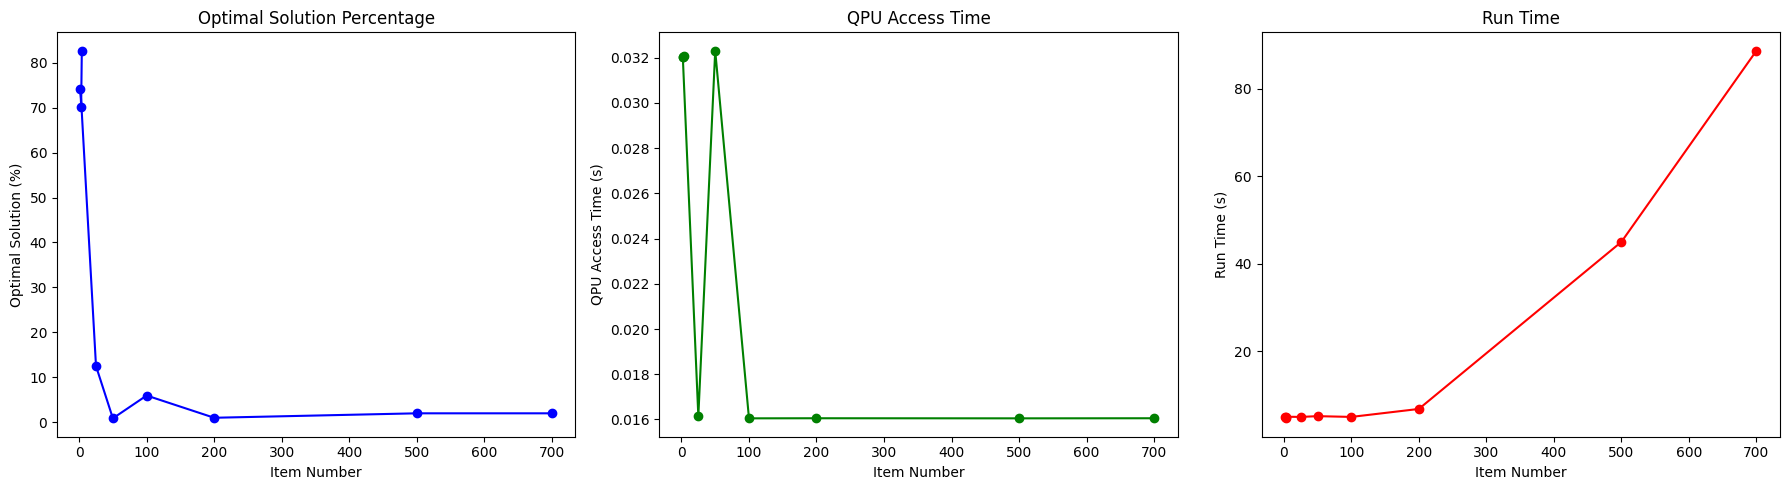

In [124]:
# Extract values for plotting
item_nums = [
    int(key.split(",")[0].split("item_num")[1]) for key in annealing_result_dict.keys()
]
optimal_solution_percentages = [value[2] for value in annealing_result_dict.values()]
qpu_access_times = [value[3] for value in annealing_result_dict.values()]
run_times = [value[4] for value in annealing_result_dict.values()]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot for Optimal solution percentage
axes[0].plot(item_nums, optimal_solution_percentages, marker="o", color="blue")
axes[0].set_title("Optimal Solution Percentage")
axes[0].set_xlabel("Item Number")
axes[0].set_ylabel("Optimal Solution (%)")

# Plot for QPU access time
axes[1].plot(item_nums, qpu_access_times, marker="o", color="green")
axes[1].set_title("QPU Access Time")
axes[1].set_xlabel("Item Number")
axes[1].set_ylabel("QPU Access Time (s)")

# Plot for Run time
axes[2].plot(item_nums, run_times, marker="o", color="red")
axes[2].set_title("Run Time")
axes[2].set_xlabel("Item Number")
axes[2].set_ylabel("Run Time (s)")

plt.tight_layout()
plt.show()

### Summary

I explored three methods for solving a combinatorial optimization problem (bin packing): a classical approach (CPLEX), a Quantum Variational Approach, and Quantum Annealing.

- **Classical Approach (CPLEX)**: Using the free version of CPLEX, I was able to solve problems with up to 25 items. This limitation is due to constraints of the free version, not the algorithm itself, which can generally handle larger problem sizes.

- **Quantum Variational Approach**: I tested two ansatzes, QAOA and EfficientSU2, which could solve problems with up to 4 items on the local Aer simulator. Running these on IBM Cloud was infeasible under the free plan due to job limits and lack of session execution mode. QAOA’s customizable mixer allows quantum state evolution within the bin assignment constraints, making it a better fit than EfficientSU2, though EfficientSU2 remains highly configurable. With better access to quantum resources and a reasonable decompose/recombine strategy, it is likely that this approach could scale for larger problems.

- **Quantum Annealing Approach (D-Wave)**: Using D-Wave’s quantum annealer, I was able to solve problems with up to 700 items on a developer plan. Although it’s difficult to gauge accuracy beyond 25 items without direct comparison, the algorithm performed efficiently on larger problem sizes.

### Conclusion
Given access limitations with free plans on these platforms, Quantum Annealing appears best suited for this optimization problem due to its scalability and efficiency in handling larger item counts.

*Note: Experiment results are included in the GitHub repository.*

